# `StableReparam` posteriors

This notebook examines the posteriors over the four latent variables introduced by `StableReparam`, conditioned on a single datum and the `Stable` parameters. Our goal is to assess the accuracy of an `AutoNormal` approximation to this posterior, addressing [Pyro issue #3280](https://github.com/pyro-ppl/pyro/issues/3280).

In [129]:
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.distributions import constraints
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.mcmc import MCMC, NUTS
from pyro.infer.reparam import StableReparam
from pyro.nn.module import PyroModule, PyroParam
from pyro.optim import ClippedAdam
import matplotlib as mpl
import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float64)
pyro.set_rng_seed(20231006)
mpl.rcParams['figure.facecolor'] = 'white'

In [130]:
stability = 1.9
skew = 0.5
scale = 1.0
loc = 0.0
stable = dist.Stable(stability, skew, scale, loc)

In [131]:
@poutine.reparam(config={"x": StableReparam()})
def model(data: torch.Tensor):
    with pyro.plate_stack("data", data.shape):
        pyro.sample("x", stable, obs=data)

Let's sample some representative points.

In [132]:
data = stable.sample([10001])
data, _ = data.sort()
data.shape

torch.Size([10001])

Text(0.5, 1.0, 'Approximate CDF')

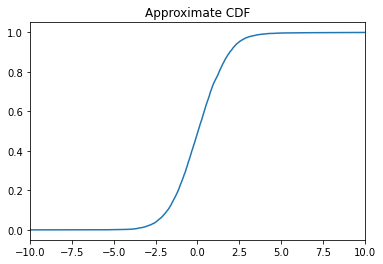

In [133]:
plt.plot(data, torch.linspace(0, 1, len(data)))
plt.xlim(-10, 10)
plt.title("Approximate CDF")

In [134]:
quantiles = torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0])

In [135]:
# draw samples using Pyro's NUTS
kernel = NUTS(model)
mcmc = MCMC(kernel, num_samples=4000, warmup_steps=400)
mcmc.run(quantiles)
samples = mcmc.get_samples()

Sample: 100%|████████████████████████████████████████| 4400/4400 [01:24, 52.35it/s, step size=1.96e-01, acc. prob=0.914]                


In [136]:
{k: v.shape for k, v in sorted(samples.items())}

{'x_t_exponential': torch.Size([4000, 5]),
 'x_t_uniform': torch.Size([4000, 5]),
 'x_z_exponential': torch.Size([4000, 5]),
 'x_z_uniform': torch.Size([4000, 5])}

In [137]:
z = torch.stack([v for k, v in sorted(samples.items())], dim=-1)
z.shape

torch.Size([4000, 5, 4])

In [138]:
mcmc.transforms

{'x_z_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_z_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 ),
 'x_t_uniform': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(SigmoidTransform())
 ),
 'x_t_exponential': ComposeTransform(
     _InverseTransform(AffineTransform()),
     _InverseTransform(ExpTransform())
 )}

In [139]:
z_unconstrained = torch.stack(
    [mcmc.transforms[k](v) for k, v in sorted(samples.items())],
    dim=-1
)

In [154]:
def plot_pairs(data_index: int) -> None:
    """lots a 4x4 grid of pairwise scatter plots for each of the four dimensions"""
    samples = z_unconstrained[:, data_index, :].numpy()
    assert samples.shape == (len(samples), 4)
    fig, axs = plt.subplots(4, 4, figsize=(8, 8))
    for i in range(4):
        for j in range(4):
            if i == j:
                axs[i, j].hist(samples[:, i], bins=50, lw=0)
                # draw a smoothed histogram
            else:
                axs[i, j].scatter(samples[:, j], -samples[:, i], s=5, alpha=0.3, lw=0)
            if i < 3:
                axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
    fig.suptitle(f"reparam z | x = {quantiles[data_index]:0.5g}", fontsize=16)
    plt.subplots_adjust(wspace=0, hspace=0)

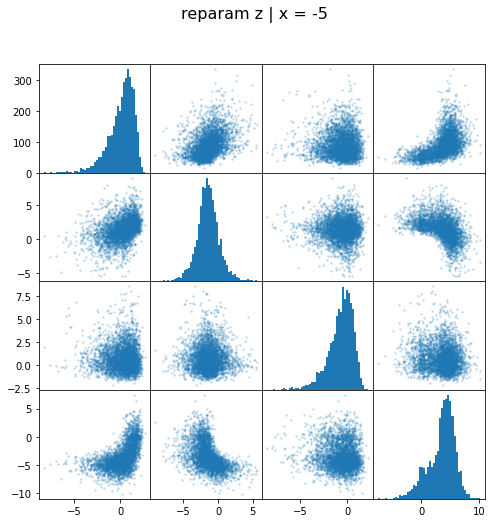

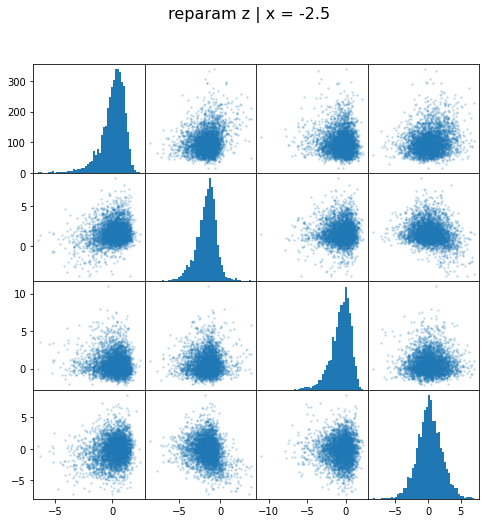

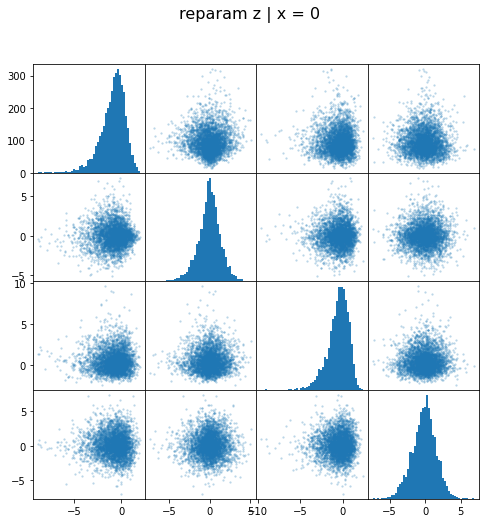

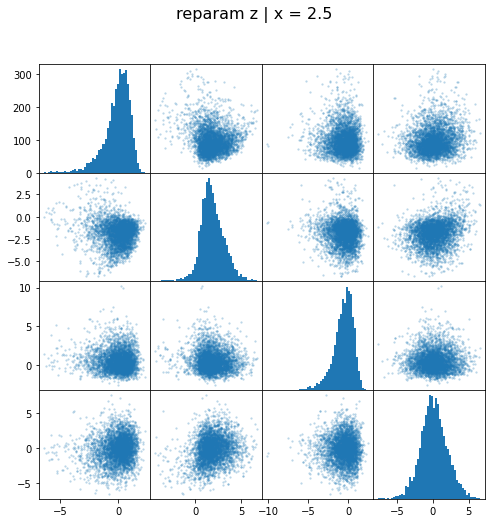

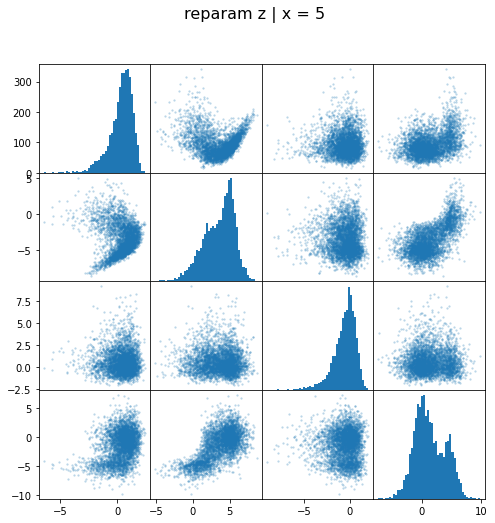

In [141]:
for i in range(len(quantiles)):
    plot_pairs(i)

## Fitting a conditional normalizing flow

Let's fit a conditional normalizing flow that depends only on the data point. In a real application we'd want to additionally depend on the local parameters of the stable distribution (stability, skew, scale, and loc).

In [198]:
pyro.set_rng_seed(20231007)
data = stable.sample([1000])

In [193]:
class FlowGuide(PyroModule):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 4 * 2),
        )
        self.net[-1].bias.data[4:] = -10  # initialize to small scale

    def forward(self, data: torch.Tensor):
        with pyro.plate_stack("data", data.shape):
            params = self.net(data[..., None].sigmoid() * 2 - 1)
            loc = params[..., :4]
            scale = torch.nn.functional.softplus(params[..., 4:])
            z_dist = dist.Normal(loc, scale).to_event(1)
            z_unconstrained = pyro.sample(
                "z", z_dist, infer={"is_auxiliary": True},
            )
            z_u, z_e, t_u, t_e = z_unconstrained.unbind(-1)
            z_u = z_u.sigmoid()
            z_e = z_e.exp()
            t_u = t_u.sigmoid()
            t_e = t_e.exp()
            pyro.sample("x_z_uniform", dist.Delta(z_u))
            pyro.sample("x_z_exponential", dist.Delta(z_e))
            pyro.sample("x_t_uniform", dist.Delta(t_u))
            pyro.sample("x_t_exponential", dist.Delta(t_e))
        return z_unconstrained

In [194]:
pyro.clear_param_store()
pyro.set_rng_seed(20231007)

num_steps = 1001
guide = FlowGuide()
elbo = Trace_ELBO()
optim = ClippedAdam({"lr": 0.001, "lrd": 0.1**(1 / num_steps)})
svi = SVI(model, guide, optim, elbo)
losses = []
for step in range(num_steps):
    loss = svi.step(data) / len(data)
    losses.append(loss)
    if step % 100 == 0:
        print(f"step: {step: >4d} loss: {loss:0.5g}")

step:    0 loss: 81.961
step:  100 loss: 69.186
step:  200 loss: 46.587
step:  300 loss: 16.993
step:  400 loss: -4.3795
step:  500 loss: -8.6145
step:  600 loss: -5.6867
step:  700 loss: -10.077
step:  800 loss: -11.051
step:  900 loss: -11.247
step: 1000 loss: -11.573


(-11.572877855221837, 81.9612105836356)

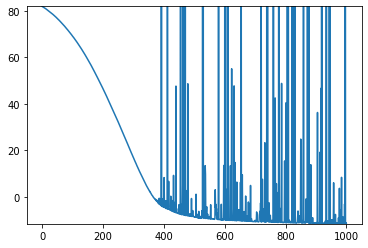

In [195]:
plt.plot(losses)
plt.ylim(min(losses), losses[0])

In [196]:
num_samples = 4000
with torch.no_grad():
  z_unconstrained = guide(torch.tensor([-5.0, -2.5, 0.0, 2.5, 5.0]).expand(num_samples, -1))
z_unconstrained.shape

torch.Size([4000, 5, 4])

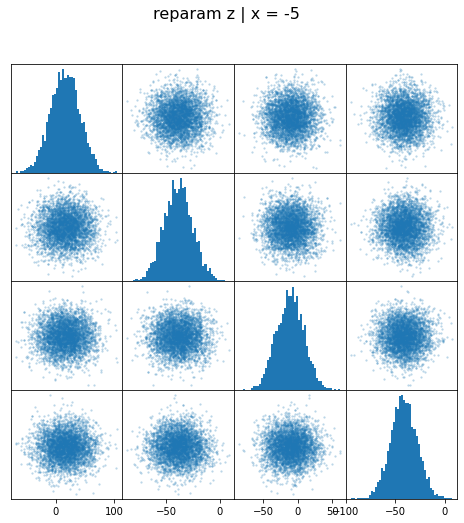

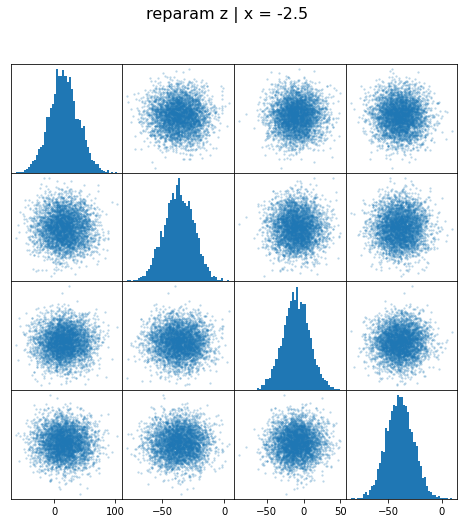

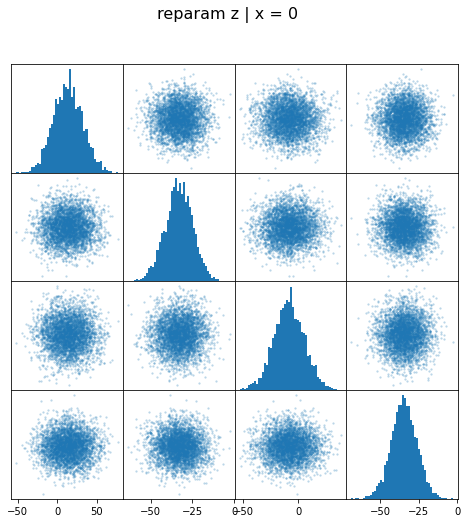

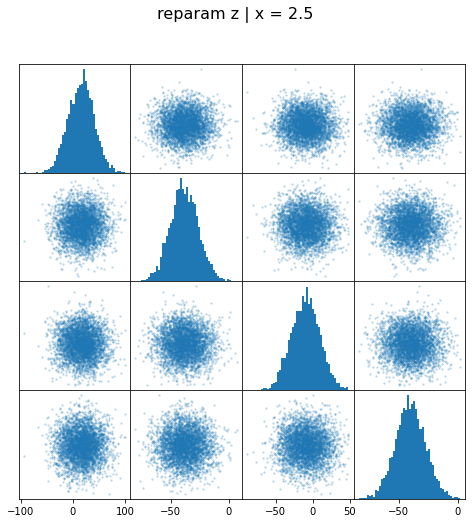

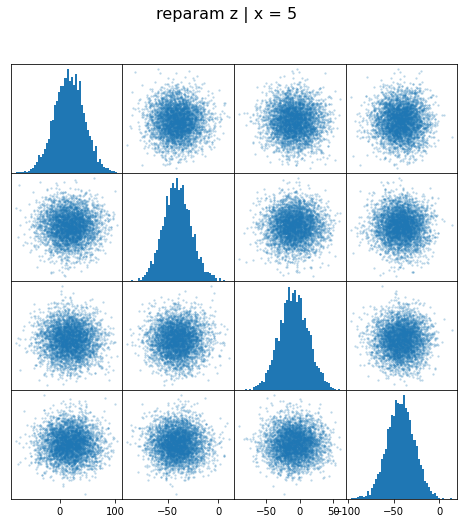

In [197]:
for i in range(len(quantiles)):
  plot_pairs(i)

Something is going wrong :-/